

> <h1 style="text-align:center;"><font color="coral"> Neural Eyes</font> Smarter Vision for Brain Tumor Detection</h1>




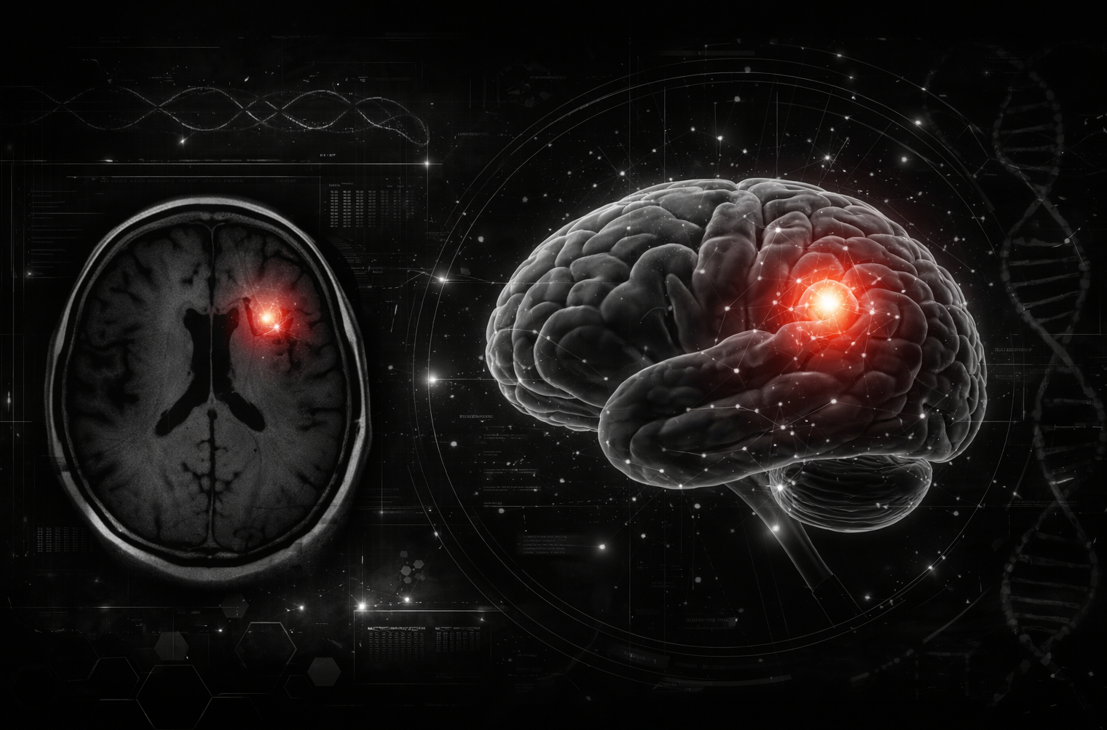



> ***Built with curiosity driven by a passion for medicine powered by deep learning and created with the mindset of a data scientist turning data into meaningful insight***



<font color="#5097a4">***~ Rana Alsattari | Data Scientist***


#Importing all Librarys we need over here

In [1]:
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import math
import random
import os
import seaborn as sns
import keras
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D, Flatten
from keras.models import Model, Sequential
import cv2
import imutils
import shutil
from keras.regularizers import l2
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler


In [5]:
!unzip '/content/brain tumor dataset.zip'

Archive:  /content/brain tumor dataset.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_dataset/no/28 no.jpg

Count the images in each directory in the main root brain tumor



---



#Going through the DATA

In [6]:
root='/content/brain_tumor_dataset'
DI_img={}
for dir in os.listdir(root):
  DI_img[dir] = len(os.listdir(os.path.join(root,dir)))
DI_img

{'yes': 155, 'no': 98}

Text(0.5, 1.0, 'No Tumor')

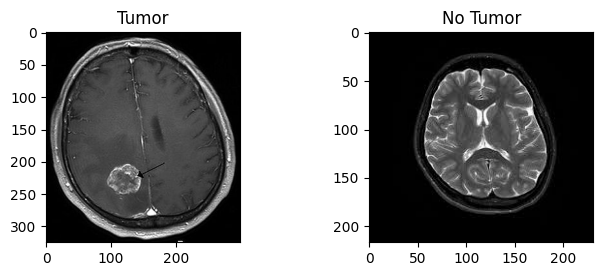

In [7]:
from keras.src.utils.image_utils import load_img
plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.imshow(load_img(os.path.join('yes' ,os.listdir('yes')[2])))
plt.title('Tumor')


plt.subplot(2,2,2)
plt.imshow(load_img(os.path.join('no', os.listdir('no')[1])))
plt.title('No Tumor')

Text(0.5, 1.0, 'Tumor')

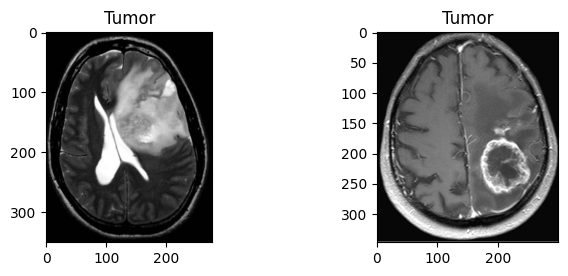

In [8]:
from keras.src.utils.image_utils import load_img
plt.figure(figsize=(8,6))

plt.subplot(2,2,1)
plt.imshow(load_img(os.path.join('yes' ,os.listdir('yes')[114])))
plt.title('Tumor')

from keras.src.utils.image_utils import load_img
plt.subplot(2,2,2)
plt.imshow(load_img(os.path.join('yes' ,os.listdir('yes')[55])))
plt.title('Tumor')


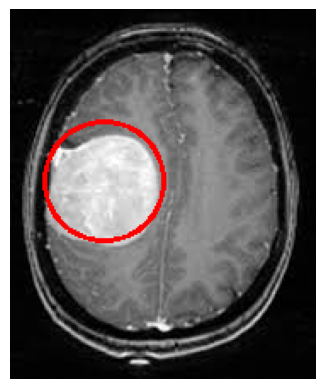

In [133]:

import cv2
import matplotlib.pyplot as plt
img = cv2.imread('/content/yes/Y1.jpg')

#the circle will show the tumor on the brain
cv2.circle(img, (55, 101), 35, (0,0,255), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

#so the shining part is a tumor


you can clearly see the tumor here the bright area inside the circle shows where it is and this helps us understand what the model is actually looking at



---



#Augmentation technique

In this step, I used data augmentation to create multiple variations of the original images using techniques like rotation, shifting, flipping, and brightness adjustment. This was done to increase the dataset size and help the model learn better patterns, improving its performance and reducing overfitting.

In [10]:
def agment_img(fileDir, n_samples, save_to_dir):
  data_generate= ImageDataGenerator(rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    brightness_range=(0.1,0.3),
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest',
                                    rescale=1/255)
  for filename in os.listdir(fileDir):
    image = cv2.imread(fileDir + '/' + filename)
    #reshape img
    image=image.reshape((1,)+image.shape)
    save_prefix= 'aug_' + filename[:-4]
    i=0

    for batch in data_generate.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_samples:
                    break


In [11]:
name= 'augmented_Data'
if not os.path.exists("./"+name):
  os.mkdir("./"+name)
  for dir in os.listdir(root):
    os.makedirs("./"+name+"/"+dir)
  else:
    print(f"{name} already there bruh!")


augmented_Data already there bruh!


In [12]:
agment_img(fileDir= './brain_tumor_dataset/yes', n_samples=8, save_to_dir='./augmented_Data/yes')

In [13]:
agment_img(fileDir= './brain_tumor_dataset/no', n_samples=8, save_to_dir='./augmented_Data/no')

In [14]:
root='/content/augmented_Data'
DI_img={}
for dir in os.listdir(root):
  DI_img[dir] = len(os.listdir(os.path.join(root,dir)))
DI_img

{'yes': 1395, 'no': 882}

#Spliting the Data

The dataset was split into training, validation, and testing sets using a 70-15-15r

<br>

**Rana why is dataset splitting important?**

<br>

This step ensures that the model learns meaningful patterns from the training data, is optimized using validation data, and is fairly evaluated on completely unseen data. This reduces overfitting and provides a more realistic measure of the model’s performance.


In [15]:
root = "/content/augmented_Data"
output = "/content/split_dataset"  # creating a new folder to store the splitied data

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


for folder in ["train", "val", "test"]:
    os.makedirs(os.path.join(output, folder), exist_ok=True)


for class_name in os.listdir(root):

    class_path = os.path.join(root, class_name)

    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)

    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    train_imgs = images[:train_end]
    val_imgs = images[train_end:val_end]
    test_imgs = images[val_end:]



    for folder in ["train", "val", "test"]:
        os.makedirs(os.path.join(output, folder, class_name), exist_ok=True)



    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img),
                    os.path.join(output, "train", class_name, img))

    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img),
                    os.path.join(output, "val", class_name, img))

    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img),
                    os.path.join(output, "test", class_name, img))


print(" Dataset split completed!")


 Dataset split completed!


In [16]:
root='/content/split_dataset/test'
DI_img={}
for dir in os.listdir(root):
  DI_img[dir] = len(os.listdir(os.path.join(root,dir)))
DI_img


{'yes': 210, 'no': 133}

In [17]:
root='/content/split_dataset/train'
DI_img={}
for dir in os.listdir(root):
  DI_img[dir] = len(os.listdir(os.path.join(root,dir)))
DI_img

{'yes': 976, 'no': 617}

In [18]:
root='/content/split_dataset/val'
DI_img={}
for dir in os.listdir(root):
  DI_img[dir] = len(os.listdir(os.path.join(root,dir)))
DI_img

{'yes': 209, 'no': 132}



---



#Preprocessing


Here I cropped the brain images so the model only sees the important part and not the extra background the goal is to make learning easier and help the model focus on real patterns instead of useless details


In [19]:
#a func that does brain crop

def crop_brain (image, plot=False):

  g=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  g=cv2.GaussianBlur(g,(5,5), 0)

  thresh = cv2.threshold(g, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

#finding contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

    #and those are the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])

  new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

  if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

  return new_image



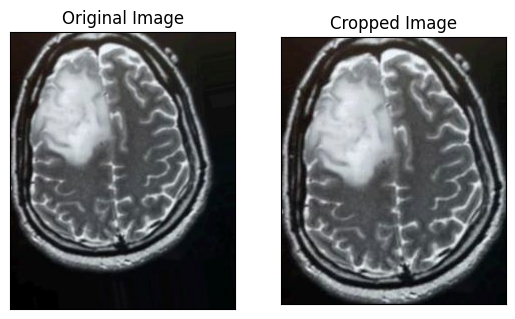

In [20]:
e_img=cv2.imread('/content/split_dataset/test/yes/aug_Y113_0_8864.jpg')
img = crop_brain(e_img, plot=True)

#perfect!!!!

Yay the crop worked the background is removed and now the brain is the main focus which is exactly what we want before sending the images to the model




---



In [21]:
def load_data(dlist, im_size):

  x= []
  y= []

  image_width, image_height = im_size

  for directory in dlist:
        for filename in os.listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)

            image = image / 255.

            x.append(image)

            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])


  x = np.array(x)
  y = np.array(y)

  x,y = shuffle(x,y)

  print(f'Num of ex is: {len(x)}')
  print(f'x shape is: {x.shape}')
  print(f'y shape is: {y.shape}')

  return x,y

In [22]:

IMG_WIDTH, IMG_HEIGHT = (240, 240)

x_train, y_train = load_data(['/content/split_dataset/train/yes','/content/split_dataset/train/no'], (IMG_WIDTH, IMG_HEIGHT))

Num of ex is: 1593
x shape is: (1593, 240, 240, 3)
y shape is: (1593, 1)




---



#plotting images

I plotted multiple brain images from both classes just to visually check the data and get a better feel of what the model will be trained on always good to see your dataset before jumping into training

In [23]:
def plot_images(x, y, n=40):
    for label in [0,1]:

        images = x[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 8
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(12, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])


            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Patient has Tumer in his brain!!" if label == 1 else "No Tumer, he is safe!!"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

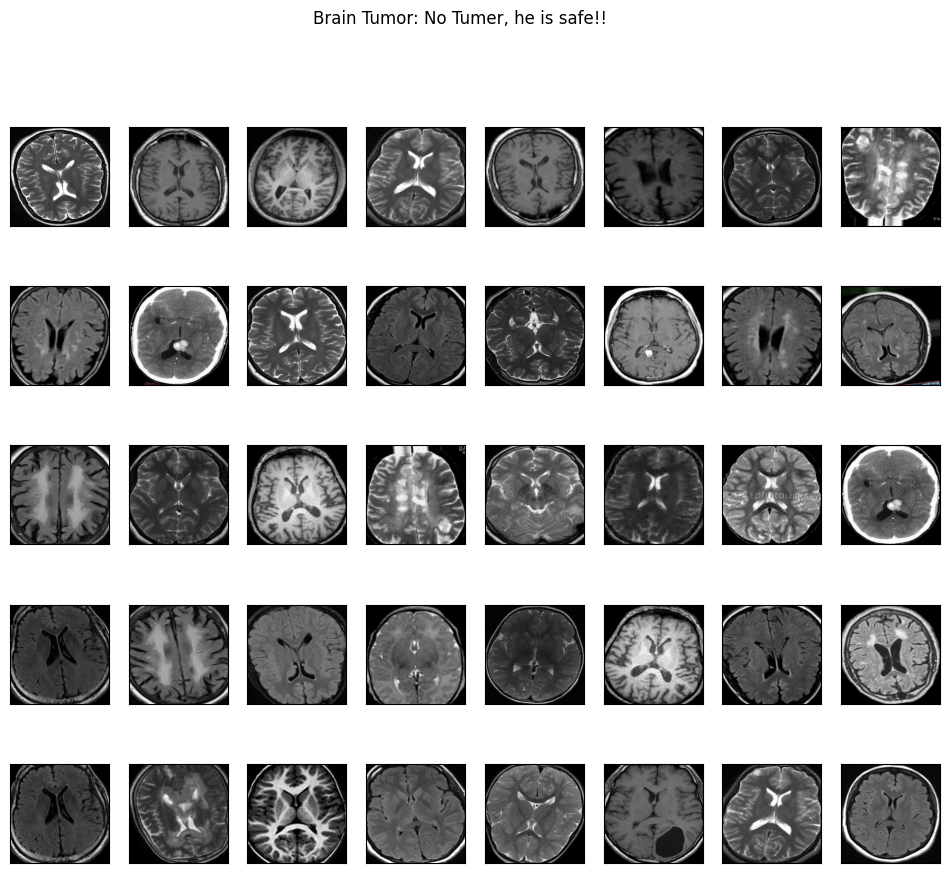

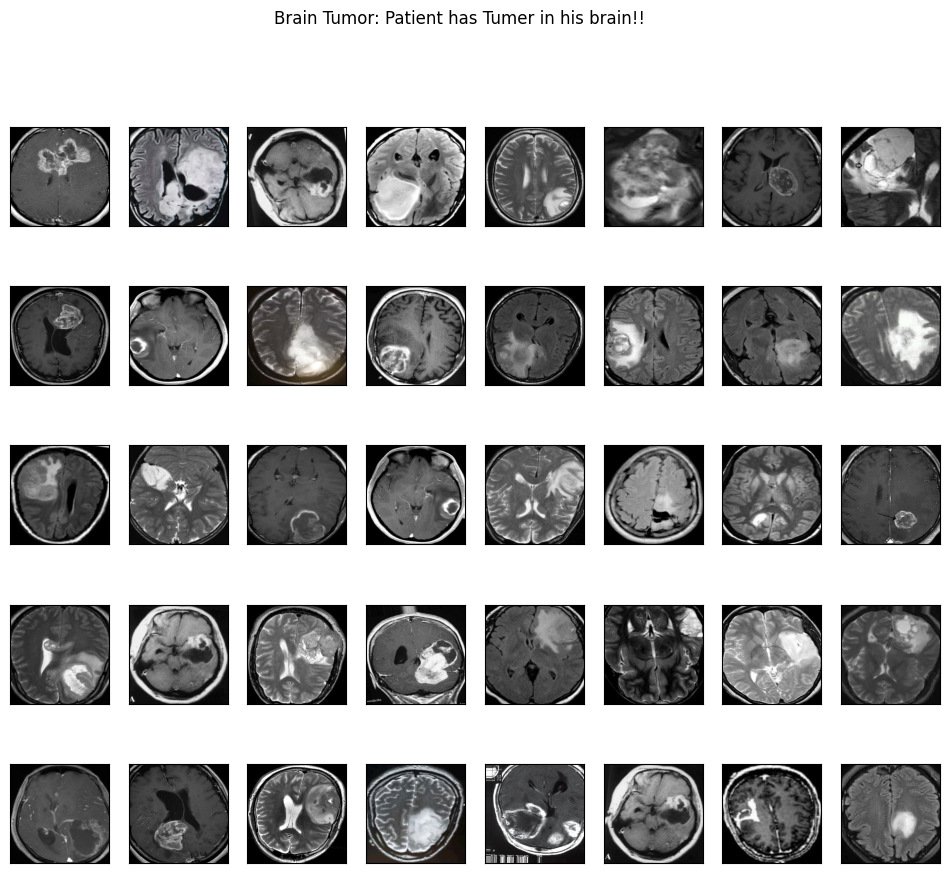

In [24]:
plot_images(x_train,y_train)

seeing the images like this makes everything more real you can clearly notice the difference between normal brains and tumor cases which is exactly what we want the model to learn



---



#now testing the data


loaded the testing and validation data and prepared it so the model can read it this step makes sure the data is organized and ready before evaluating the model and seeing how well it performs


In [134]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)
x_test, y_test = load_data(['/content/split_dataset/test/yes', '/content/split_dataset/test/no'], (IMG_WIDTH, IMG_HEIGHT))


Num of ex is: 343
x shape is: (343, 240, 240, 3)
y shape is: (343, 1)


In [26]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)
x_val, y_val = load_data(['/content/split_dataset/val/yes', '/content/split_dataset/val/no'], (IMG_WIDTH, IMG_HEIGHT))


Num of ex is: 341
x shape is: (341, 240, 240, 3)
y shape is: (341, 1)


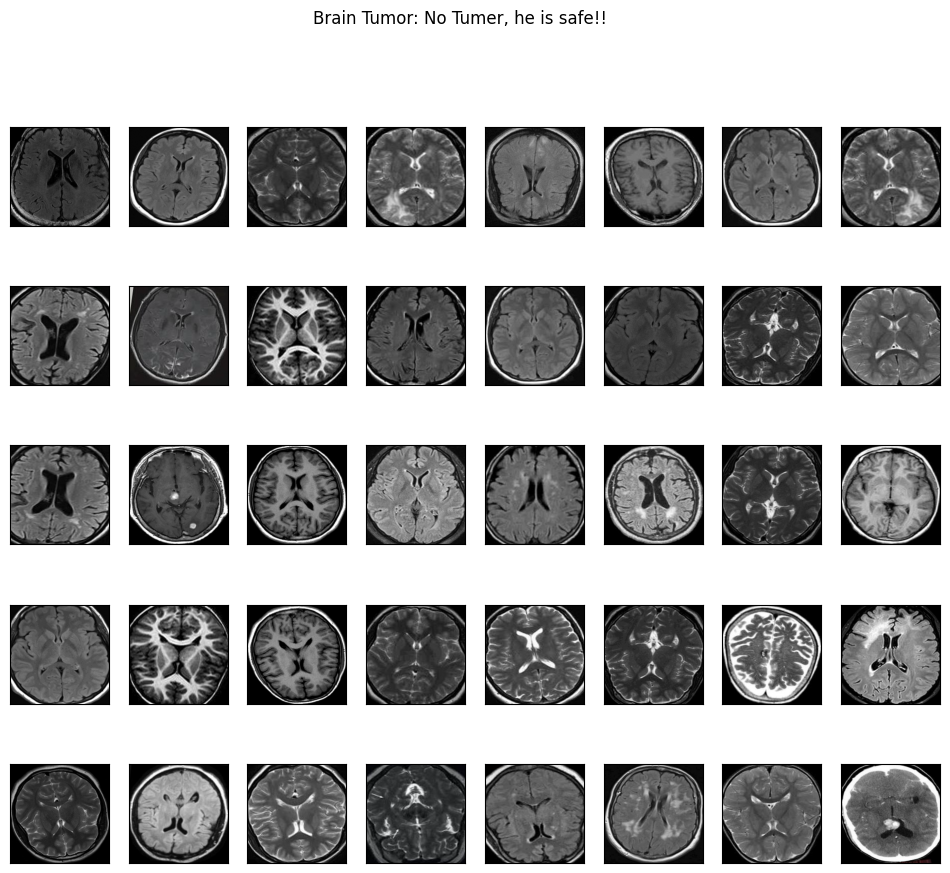

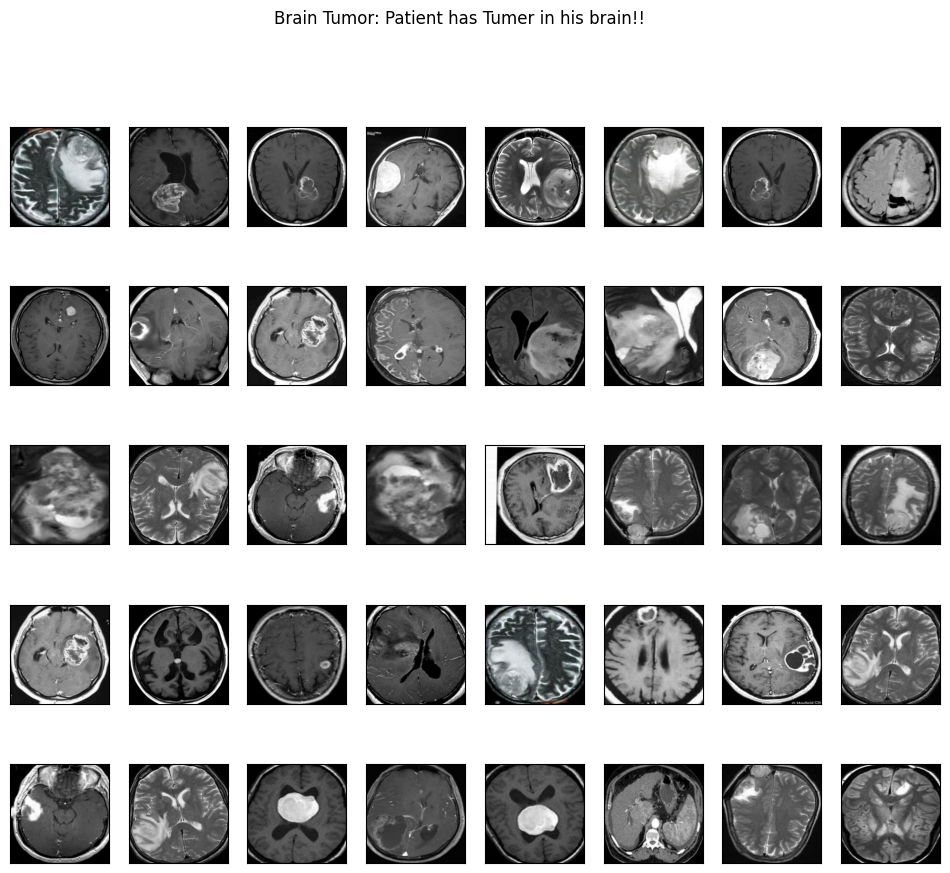

In [27]:
plot_images(x_val, y_val)



---



#CNN Model

Here I built a CNN model to help detect whether a brain has a tumor or not the model looks at the images learns patterns step by step and gets better at telling the difference between normal and tumor brains the dropout layers are added to prevent overfitting so the model does not just memorize the data but actually learns from it


In [95]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (240, 240, 3)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())

model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.25))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)              │ (None, 238, 238, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 236, 236, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 118, 118, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 116, 116, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,520,097 (24.87 MB)

 Trainable params: 6,520,097 (24.87 MB)

 Non-trainable params: 0 (0.00 B)

The model has multiple convolution layers to detect important features from the brain images max pooling layers to reduce the image size and keep the strongest details dropout layers to avoid overfitting flatten to convert the data into one long vector and dense layers that make the final decision if there is a tumor or not


In [96]:
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])



In [97]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor ='val_accuracy', filepath = './bestmodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cd = [es, mc]

In [98]:


modelTrain = model.fit(x = x_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (x_val, y_val), callbacks = cd, verbose = 1)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5488 - loss: 0.8941
Epoch 1: val_accuracy improved from -inf to 0.61290, saving model to ./bestmodel.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.5496 - loss: 0.8910 - val_accuracy: 0.6129 - val_loss: 0.6591
Epoch 2/30
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6137 - loss: 0.6541
Epoch 2: val_accuracy improved from 0.61290 to 0.70968, saving model to ./bestmodel.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6138 - loss: 0.6539 - val_accuracy: 0.7097 - val_loss: 0.5692
Epoch 3/30
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7250 - loss: 0.5435
Epoch 3: val_accuracy did not improve from 0.70968
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7253 - loss: 0.5435 - val_accuracy: 0.7067 - val_loss: 0.5245
Epoch 4/30
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7628 - loss: 0.4958
Epoch 4: val_accuracy improved from 0.70968 to 0.76833, saving model to ./bestmodel.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7633 - loss: 0.4948 - val_accuracy: 0.7683 - val_loss: 0.4544
Epoch 5/30
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8006 - loss: 0.4096
Epoch 5: val_accuracy improved from 0.76833 to 0.79179, saving model to ./bestmodel.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8014 - loss: 0.4083 - val_accuracy: 0.7918 - val_loss: 0.4470
Epoch 6/30
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8346 - loss: 0.3710
Epoch 6: val_accuracy improved from 0.79179 to 0.83871, saving model to ./bestmodel.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8351 - loss: 0.3698 - val_accuracy: 0.8387 - val_loss: 0.3914
Epoch 7/30
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8901 - loss: 0.2600
Epoch 7: val_accuracy improved from 0.83871 to 0.88856, saving model to ./bestmodel.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8901 - loss: 0.2599 - val_accuracy: 0.8886 - val_loss: 0.3448
Epoch 8/30
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8969 - loss: 0.2361
Epoch 8: val_accuracy did not improve from 0.88856
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8974 - loss: 0.2354 - val_accuracy: 0.8739 - val_loss: 0.3738
Epoch 9/30
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9300 - loss: 0.1683
Epoch 9: val_accuracy did not improve from 0.88856
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9299 - loss: 0.1682 - val_accuracy: 0.8827 - val_loss: 0.4654
Epoch 10/30
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9276 - loss: 0.1549
Epoch 10: val_accuracy did not improve from 0.88856
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9278 - loss: 0.1546 - val_accuracy: 0.8739 - val_loss: 0.4274
Epoch 11/30
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9498 - loss: 0.1137
Epoch 11: val_accuracy did not improve f

The model kept getting better with each epoch accuracy was going up and loss was going down which means it was actually learning at some point the validation accuracy stopped improving so early stopping stepped in and saved the best version of the model before it started overfitting




---



# **let's check how everything looks regarding the model**

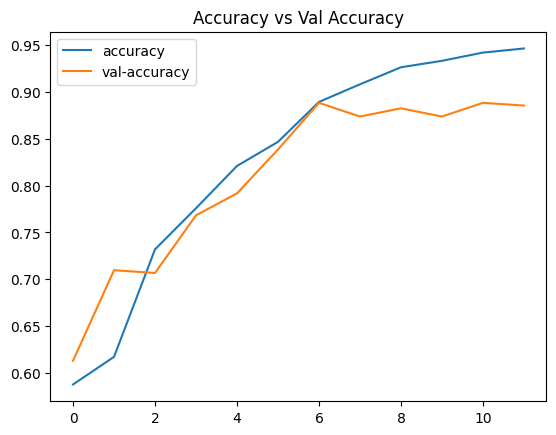

In [99]:
h = modelTrain.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

see the model improving over time both training and validation accuracy are going up which is a very good sign near the end the training accuracy gets higher than validation which hints at a little overfitting but overall the model learned well and is performing strong

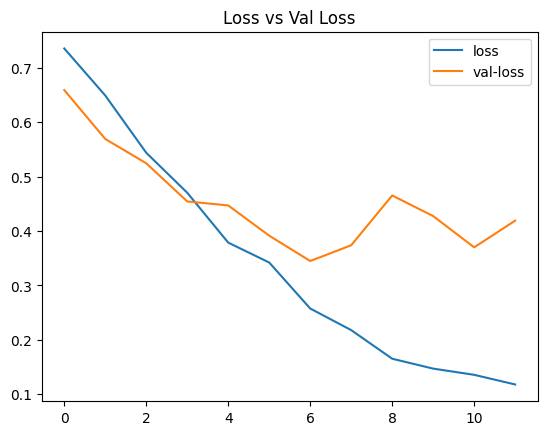

In [100]:
h = modelTrain.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

The loss keeps dropping which means the model is learning and making fewer mistakes over time validation loss also goes down at the beginning but starts moving up a little later which suggests the model is starting to slightly overfit but overall the learning process looks healthy




---



In [102]:
from keras.models import load_model
model = load_model('/content/bestmodel.h5')
acc = model.evaluate(x_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8482 - loss: 0.3590
The accuracy of our model is 0.8629737496376038


Finally I tested the model on completely unseen data and it achieved an accuracy of around 86 percent which is a strong result and shows that the model is able to generalize well and make reliable predictions




---



#yoooww Let's try the model

I tested the model on images it never saw before because I dont want it to just memorize the training set like memorizing answers for an exam the goal is to see if it can actually generalize and make correct predictions on new real images not just the ones it trained on

In [120]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_and_show(path):
    ٍٍ
    img = cv2.imread(path)
    img = crop_brain(img, plot=False)
    img = cv2.resize(img, (240,240))

    img_norm = img / 255.0
    img_input = np.expand_dims(img_norm, axis=0)

    prob = model.predict(img_input)[0][0]
    label = "There's a Tumor :(  " if prob >= 0.5 else "No Tumor yayyy!"

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{label} ({prob*100:.1f}%)")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


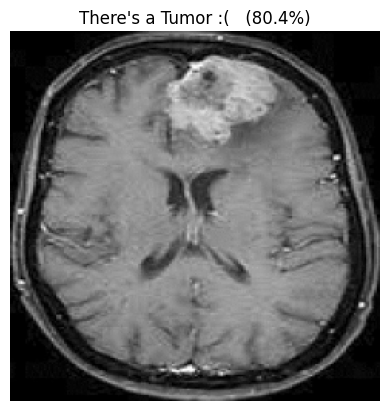

In [121]:
predict_and_show('/content/41598_2023_41576_Fig1_HTML.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


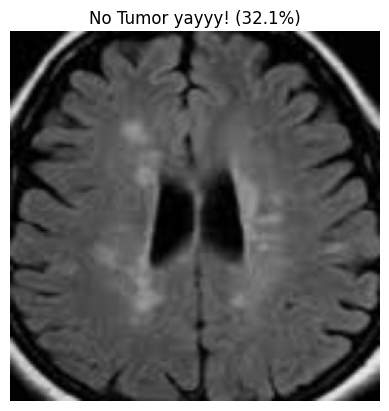

In [122]:
predict_and_show('/content/MRI Image no tumor.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


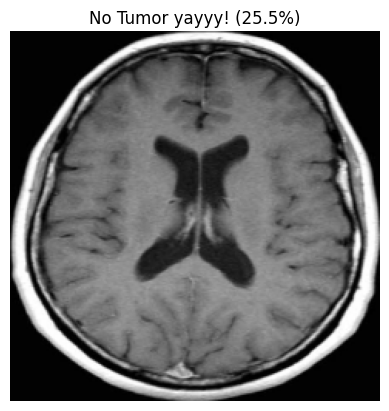

In [123]:
predict_and_show('/content/Figure-A-Axial-T1-MRI-with-contrast-shows-no-evidence-of-a-brain-tumor.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


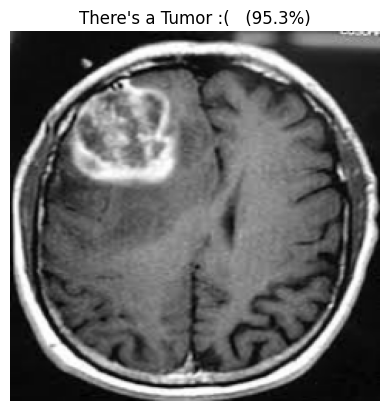

In [125]:
predict_and_show('/content/images (2).jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


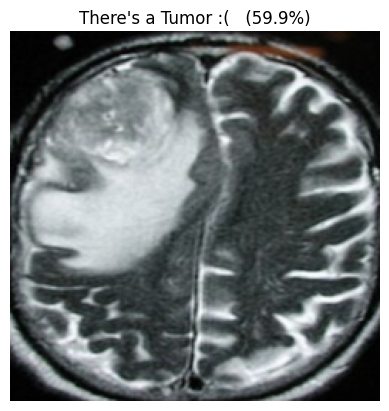

In [126]:
predict_and_show('/content/300px-Glioblastoma2.jpg')



---



#Different Skull Angles? will it identify the tumor?

**OK now the model performed well on the test images so I decided to challenge it by using an MRI taken from a different angle and position not only the top view it was trained on this helps me see if the model can handle variations in real world data**

**The goal is to confirm that the model is recognizing actual tumor patterns and not just memorizing the dataset if it can correctly predict on these different images then it means the model is learning in a smarter way**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


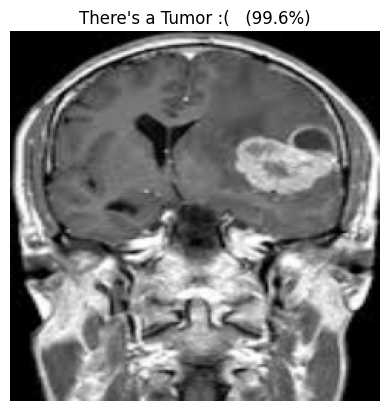

In [127]:
predict_and_show('/content/images.jpg')

As you can see in this image the skull looks different from the images used during training yet the model was still able to correctly detect the tumor this shows that the model can handle different brain positions and is learning real features instead of just memorizing the dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


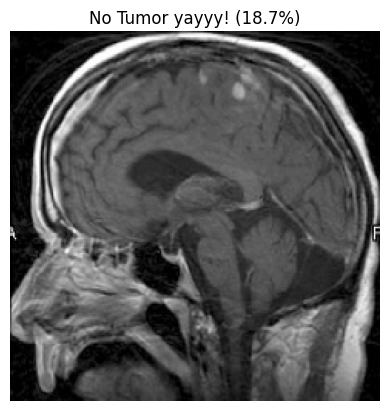

In [128]:
predict_and_show('/content/Sagittal-T1-weighted-brain-MRI-scan-with-contrast-showing-slight-enhancement-of-the-tumor.png')

Here I tested the model on another MRI taken from a side view and it correctly predicted that there is no tumor even though this angle is different from most of the training images this gives more confidence that the model can generalize well and make reliable predictions on unfamiliar data


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


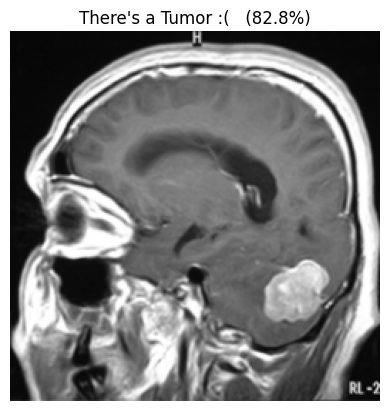

In [129]:
predict_and_show('/content/Brain-MRI-scan-showing-an-infratentorial-mass-in-the-cerebellum.png')

In this example the MRI is taken from a side angle and the model was still able to detect the tumor with strong confidence this is important because it shows the model is not dependent on one specific view and can recognize tumors even when the brain appears in different positions


#Why I built this CNN model?

**I built this project because I am genuinely interested in the intersection between medicine and technology and there is something exciting about teaching a model how to see and detect what the human eye looks for building this CNN was not just about writing code it was about creating something that could one day support real medical decisions**

<br>

**What made this even more fun is watching the model improve and actually understand the patterns instead of memorizing images it performed strongly not only on familiar views but also on MRIs taken from completely different angles which shows that it learned how to recognize tumors regardless of position**

<br>

**Seeing the model make correct predictions on unseen data felt like a full circle moment from preprocessing the images to training the network and finally trusting it on real predictions this project pushed my skills deeper into deep learning and made me even more curious to explore how AI can contribute to healthcare and potentially make a real impact**




---

